<div id="toc"></div>

# Forward modeling of the emission spectrum using VALD3

Tako Ishikawa, Hajime Kawahara  
created: : 2021/07/20,　　last update: 2022/10/22  

<!-- 
written with reference to :  
"exojax/examples/tutorial/Forward\ modeling.ipynb"  
"ghR/exojax_0/examples/testlines/line_strength_CO.py"  

cd ~/work

-->

This example provides how to use VALD3 for forward modeling of the emission spectrum. Currenty, we use exojax.spec.moldb as API for VALD3 because we have not implemented the VALD3 API in radis.api yet. 
Someday, we (or someone who is reading this document.) would include the VALD3 API in radis.api! 

In [1]:
from exojax.utils.grids import wavenumber_grid
from exojax.spec.rtransfer import pressure_layer 
from exojax.spec import moldb, molinfo, contdb
from exojax.spec import atomll
from exojax.spec.exomol import gamma_exomol
from exojax.spec import SijT, doppler_sigma
from exojax.spec import planck
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import vmap, jit
import numpy as np

HAPI version: 1.2.2.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

## T-P profile 

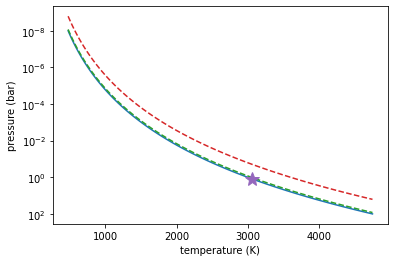

In [2]:
#Assume ATMOSPHERE                                                                     
NP=100
T0=3000. #10000. #3000. #1295.0 #K
Parr, dParr, k=pressure_layer(NP=NP)
H_He_HH_VMR = [0.0, 0.16, 0.84] #typical quasi-"solar-fraction"
Tarr = T0*(Parr)**0.1

PH = Parr* H_He_HH_VMR[0]
PHe = Parr* H_He_HH_VMR[1]
PHH = Parr* H_He_HH_VMR[2]

fig=plt.figure(figsize=(6,4))
plt.plot(Tarr,Parr)
plt.plot(Tarr, PH, '--'); plt.plot(Tarr, PHH, '--'); plt.plot(Tarr, PHe, '--')
plt.plot(Tarr[80],Parr[80], marker='*', markersize=15)
plt.yscale("log")
plt.xlabel("temperature (K)")
plt.ylabel("pressure (bar)")
plt.gca().invert_yaxis()
plt.show()

## Wavenumber

In [3]:
#We set a wavenumber grid using wavenumber_grid.
nus,wav,res = wavenumber_grid(10380, 10430, 4500, unit="AA") 

xsmode assumes ESLOG in wavenumber space: mode=lpf


## Load a database of atomic lines from VALD3

In [4]:
#Loading a database of a few atomic lines from VALD3  #BU: CO and CIA (H2-H2)... 
"""
    valdlines:  fullpath to the input line list obtained from VALD3 (http://vald.astro.uu.se/):
            VALD data access is free but requires registration through the Contact form (http://vald.astro.uu.se/~vald/php/vald.php?docpage=contact.html). 
            After the registration, you can login and select one of the following modes depending on your purpose: "Extract All", "Extract Stellar", or "Extract Element".
        For a example in this notebook, the request form of "Extract All" mode was filled as:
          Extract All
            Starting wavelength :    10380
            Ending wavelength :    10430
            Extraction format :    Long format
            Retrieve data via :    FTP
            (Hyperfine structure:    N/A)
            (Require lines to have a known value of :    N/A)
            Linelist configuration :    Default
            Unit selection:    Energy unit: eV - Medium: vacuum - Wavelength unit: angstrom - VdW syntax: default
        Please assign the fullpath of the output file sent by VALD ([user_name_at_VALD].[request_number_at_VALD].gz;  "vald2600.gz" in the code below) to the variable "valdlines".
        Note that the number of spectral lines that can be extracted in a single request is limited to 1000 in VALD (https://www.astro.uu.se/valdwiki/Restrictions%20on%20extraction%20size).
"""

valdlines = '.database/HiroyukiIshikawa.4214450.gz'
adbFe = moldb.AdbVald(valdlines, nus)


Reading VALD file


## Relative partition function

In [5]:
#Computing the relative partition function,

qt_284 = vmap(adbFe.QT_interp_284)(Tarr)
qt = np.zeros([len(adbFe.QTmask), len(Tarr)])
for i, mask in enumerate(adbFe.QTmask):
    qt[i] = qt_284[:, mask]  #e.g., qt_284[:,76] #Fe I
qt = jnp.array(qt)


## Pressure and Natural broadenings (Lorentzian width)  


In [6]:
gammaLMP = jit(vmap(atomll.gamma_vald3,(0,0,0,0,None,None,None,None,None,None,None,None,None,None,None)))\
        (Tarr, PH, PHH, PHe, adbFe.ielem, adbFe.iion, \
                adbFe.dev_nu_lines, adbFe.elower, adbFe.eupper, adbFe.atomicmass, adbFe.ionE, \
                adbFe.gamRad, adbFe.gamSta, adbFe.vdWdamp, 1.0)  

## Doppler broadening

In [7]:
sigmaDM=jit(vmap(doppler_sigma,(None,0,None)))\
    (adbFe.nu_lines, Tarr, adbFe.atomicmass)

## Line strength

In [8]:
SijM=jit(vmap(SijT,(0,None,None,None,0)))\
    (Tarr, adbFe.logsij0, adbFe.nu_lines, adbFe.elower, qt.T)

## nu matrix

In [9]:
from exojax.spec.initspec import init_lpf
numatrix=init_lpf(adbFe.nu_lines,nus)

## Compute dtau for each atomic species (or ion) in a SEPARATE array

Separate species

In [10]:
def get_unique_list(seq):
    seen = []
    return [x for x in seq if x not in seen and not seen.append(x)]

uspecies = get_unique_list(jnp.vstack([adbFe.ielem, adbFe.iion]).T.tolist())

Set the stellar/planetary parameters

In [11]:
#Parameters of Objects
Rp = 0.36*10 #R_sun*10    #Rp=0.88 #[R_jup]
Mp = 0.37*1e3 #M_sun*1e3    #Mp=33.2 #[M_jup]
g = 2478.57730044555*Mp/Rp**2
print('logg: '+str(np.log10(g))) #check

logg: 4.849799190511717


Calculate delta tau

In [12]:
#For now, ASSUME all atoms exist as neutral atoms.
#In fact, we can't ignore the effect of molecular formation e.g. TiO (」゜□゜)」

from exojax.spec.lpf import xsmatrix
from exojax.spec.rtransfer import dtauM
from exojax.spec.atomllapi import load_atomicdata

ipccd = load_atomicdata()
ieleml = jnp.array(ipccd['ielem'])
Narr = jnp.array(10**(12 + ipccd['solarA']))  #number density
massarr = jnp.array(ipccd['mass'])  #mass of each neutral atom
Nmassarr = Narr * massarr  #mass of each neutral species

dtaual = np.zeros([len(uspecies), len(Tarr), len(nus)])
maskl = np.zeros(len(uspecies)).tolist()

for i, sp in enumerate(uspecies):
    maskl[i] = (adbFe.ielem==sp[0])\
                    *(adbFe.iion==sp[1])

    #Currently not dealing with ionized species yet... (#tako %\\\\20210814)
    if sp[1] > 1:
        continue

    #Providing numatrix, thermal broadening, gamma, and line strength, we can compute cross section.
    xsm = xsmatrix(numatrix[maskl[i]], sigmaDM.T[maskl[i]].T,
                   gammaLMP.T[maskl[i]].T, SijM.T[maskl[i]].T)
    #Computing delta tau for atomic absorption
    MMR_X_I = Nmassarr[jnp.where(ieleml == sp[0])[0][0]] / jnp.sum(Nmassarr)
    mass_X_I = massarr[jnp.where(ieleml == sp[0])[0][
        0]]  #MMR and mass of neutral atom X (if all elemental species are neutral)
    dtaual[i] = dtauM(dParr, xsm, MMR_X_I * np.ones_like(Tarr), mass_X_I, g)


compute delta tau for CIA

In [13]:
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia', nus)

from exojax.spec.rtransfer import dtauCIA
mmw=2.33 #mean molecular weight
mmrH2=0.74
molmassH2=molinfo.molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #VMR
dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)

H2-H2


## Total delta tau

In [14]:
dtau = np.sum(dtaual, axis=0) + dtaucH2H2

## Plot contribution function

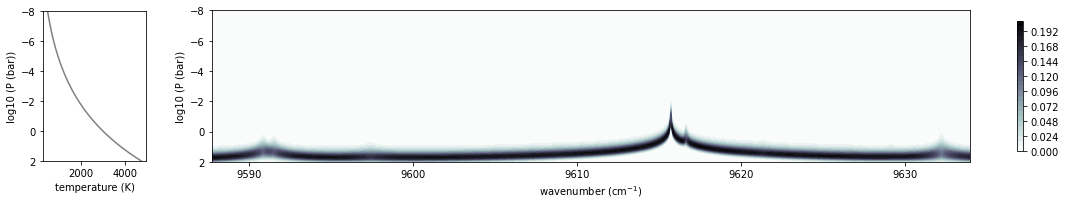

In [15]:
from exojax.plot.atmplot import plotcf
plotcf(nus,dtau,Tarr,Parr,dParr)
plt.show()

## Radiative transfer

In [16]:
from exojax.spec import planck
from exojax.spec.rtransfer import rtrun
sourcef = planck.piBarr(Tarr, nus)
F0=rtrun(dtau, sourcef)

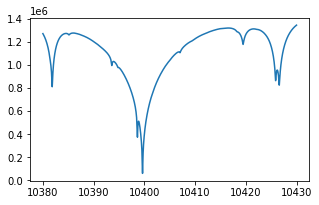

In [17]:
fig=plt.figure(figsize=(5, 3))
plt.plot(wav[::-1],F0)
plt.show()

In [18]:
#Check line species
print(np.unique(adbFe.ielem))

[12 13 14 17 18 20 21 22 24 25 26 27 28 29 32 38 59 64 65 66 70 90]


## Rotational & instrumental broadening

In [21]:
from exojax.spec import response
from exojax.utils.constants import c #[km/s]
import jax.numpy as jnp

wavd=jnp.linspace(10380, 10450,500) #observational wavelength grid
nusd = 1.e8/wavd[::-1]

RV=10.0 #RV km/s
vsini=20.0 #Vsini km/s
u1=0.0 #limb darkening u1
u2=0.0 #limb darkening u2

R=100000.
beta=c/(2.0*np.sqrt(2.0*np.log(2.0))*R) #IP sigma need check 

Frot=response.rigidrot(nus,F0,vsini,u1,u2)
F=response.ipgauss_sampling(nusd,nus,Frot,beta,RV)

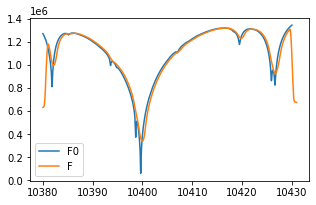

In [22]:
fig=plt.figure(figsize=(5, 3))
plt.plot(wav[::-1],F0, label='F0')
plt.plot(wavd[::-1],F, label='F')
plt.legend()
plt.show()